In [240]:
#Using Goole Colab : Mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [241]:
# import the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings('ignore')

##Problem Statement
To predict customer satisfaction.

The dataset contains information regarding clothes.
Each observation is a different fitting size with various features.

```
Product size recommendation and fit prediction are critical in order to improve customers’ shopping experiences and to reduce product return rates.
However, modeling customers’ fit feedback is challenging due to its subtle semantics,
arising from the subjective evaluation of products and imbalanced label distribution (most of the feedbacks is "Fit").
```

In [242]:
#Feature Description
feat_desc=pd.read_excel('/content/drive/MyDrive/Modelling_Customer_Feedback_Product_Recommendation/Modelling_Customer_Feedback_Data_Dictionary.xlsx')
feat_desc

,Feature,Description
0,bra_size,integer value
1,category,In which category clothes belong
2,cup_size,size of the cloth
3,fit,Target variable (fit/large/small)
4,height,Height of the customer
5,hips,Size of the hips
6,item_id,Id number
7,length,Length of the cloth
8,quality,Rating given by customer
9,size,size of the cloth


### Load the dataset


In [243]:
# read the dataset and extract the test  and train data separately
df_train=pd.read_csv('/content/drive/MyDrive/Modelling_Customer_Feedback_Product_Recommendation/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Modelling_Customer_Feedback_Product_Recommendation/test.csv')

#Dropping df_train Id column : train_id
train_id = df_train['Id']
df_train.drop(['Id'], axis=1, inplace=True)


In [244]:
#First look at data
df_train.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,136482,NaN,15,3.0,dd/e,36.0,36.0,new,NaN,5ft 4in,lakegirl74a,just right,fit,357490,NaN,NaN,NaN,NaN
1,723977,NaN,15,5.0,c,42.0,36.0,bottoms,NaN,5ft 8in,Ale,just right,fit,897280,NaN,NaN,Fit was perfect I can tuc,Fit was perfect I can tuck in a blouse comfort...
2,647551,NaN,8,4.0,b,36.0,34.0,tops,34,5ft 4in,Jessica,slightly short,large,279853,NaN,average,I wear the crap out of th,I wear the crap out of this. If I were to buy ...
3,404557,NaN,12,3.0,dd/e,44.0,32.0,new,NaN,5ft 5in,Patricia,slightly short,small,912482,NaN,NaN,This was cute but cut too,This was cute but cut too straight to fit over...
4,414857,NaN,15,3.0,d,38.0,38.0,new,NaN,5ft 9in,Carol,just right,fit,978354,NaN,NaN,"Great fit, material is so","Great fit, material is soft and of good qualit..."


In [245]:
# Data shape and columns
print(df_train.shape)
print(df_train.columns)

(66232, 18)
Index(['item_id', 'waist', 'size', 'quality', 'cup size', 'hips', 'bra size',
       'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
       'shoe size', 'shoe width', 'review_summary', 'review_text'],
      dtype='object')


In [247]:
#Features Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66232 entries, 0 to 66231
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         66232 non-null  int64  
 1   waist           2319 non-null   float64
 2   size            66232 non-null  int64  
 3   quality         66178 non-null  float64
 4   cup size        61280 non-null  object 
 5   hips            44900 non-null  float64
 6   bra size        61480 non-null  float64
 7   category        66232 non-null  object 
 8   bust            9458 non-null   object 
 9   height          65346 non-null  object 
 10  user_name       66232 non-null  object 
 11  length          66203 non-null  object 
 12  fit             66232 non-null  object 
 13  user_id         66232 non-null  int64  
 14  shoe size       22314 non-null  float64
 15  shoe width      14889 non-null  object 
 16  review_summary  60859 non-null  object 
 17  review_text     60859 non-null 

In [248]:
# Describe data
df_train.describe()

,item_id,waist,size,quality,hips,bra size,user_id,shoe size
count,66232.000000,2319.000000,66232.000000,66178.000000,44900.000000,61480.000000,66232.000000,22314.000000
mean,469609.885705,31.401897,12.683612,3.950890,40.366214,35.982563,499088.334204,8.147889
std,214195.473607,5.330146,8.287589,0.990964,5.831993,3.230949,286028.365379,1.338406
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,253207.000000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,499049.000000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744488.500000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,38.000000


In [249]:
#Describing categorical data - 'object'
df_train.describe(include='object')

,cup size,category,bust,height,user_name,length,fit,shoe width,review_summary,review_text
count,61280,66232,9458.0,65346,66232,66203,66232,14889,60859,60859
unique,12,7,75.0,40,28094,5,3,3,50263,58851
top,c,new,36.0,5ft 6in,Sarah,just right,fit,average,Love it!,Love it!
freq,14779,17106,861.0,9592,582,49596,45414,10459,149,121


In [250]:
# replace the space with _
df_train.columns=df_train.columns.str.strip().str.lower().str.replace(' ', '_')
df_test.columns=df_test.columns.str.strip().str.lower().str.replace(' ', '_')

In [251]:
# Check the percentage of missing value
missing_data = pd.DataFrame({'total_missing': df_train.isnull().sum(), 'perc_missing': (df_train.isnull().sum()/82790)*100})
print(missing_data)

                total_missing  perc_missing
item_id                     0      0.000000
waist                   63913     77.198937
size                        0      0.000000
quality                    54      0.065225
cup_size                 4952      5.981399
hips                    21332     25.766397
bra_size                 4752      5.739824
category                    0      0.000000
bust                    56774     68.575915
height                    886      1.070178
user_name                   0      0.000000
length                     29      0.035028
fit                         0      0.000000
user_id                     0      0.000000
shoe_size               43918     53.047470
shoe_width              51343     62.015944
review_summary           5373      6.489914
review_text              5373      6.489914


In [252]:
# drop the the columns
df_train.drop(['waist', 'bust', 'user_name','review_text','review_summary','shoe_size','shoe_width'], axis=1, inplace=True)
df_test.drop(['waist', 'bust', 'user_name','review_text','review_summary','shoe_size','shoe_width'], axis=1, inplace=True)

### Visualize and preprocess the data



In [253]:
#Function to plot bar graph
def plot_barh(df,col, cmap = None, stacked=False, norm = None):
    df.plot(kind='barh', colormap=cmap, stacked=stacked)
    fig = plt.gcf()
    fig.set_size_inches(24,12)
    plt.title("Category vs {}-feedback -  cloth {}".format(col, '(Normalized)' if norm else ''), fontsize= 20)
    plt.ylabel('Category', fontsize = 18)
    plot = plt.xlabel('Frequency', fontsize=18)

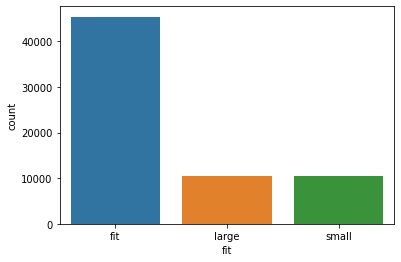

In [254]:
#Target - fit
sns.countplot(df_train['fit'])

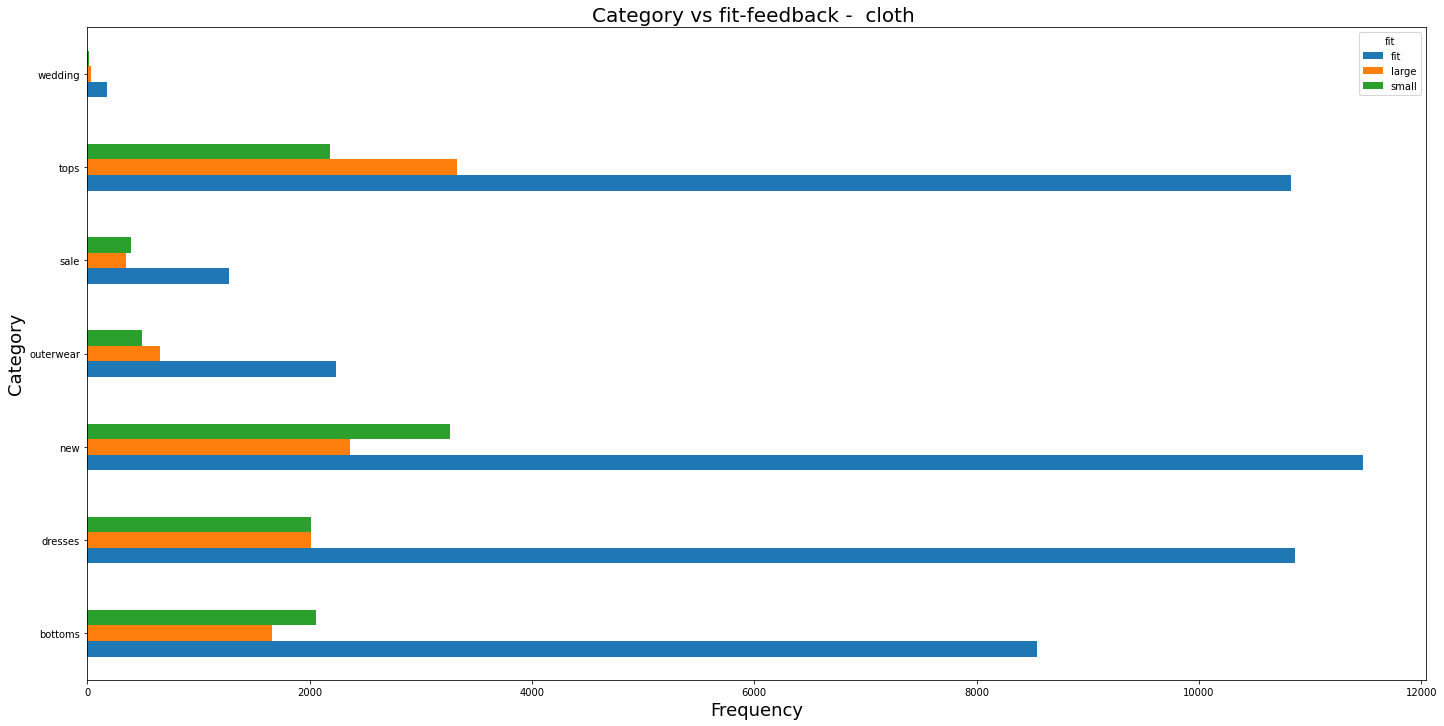

In [255]:
#Category vs fit feedback

g_by_category = df_train.groupby('category')
cat_fit = g_by_category['fit'].value_counts()
cat_fit = cat_fit.unstack()
plot_barh(cat_fit, 'fit')

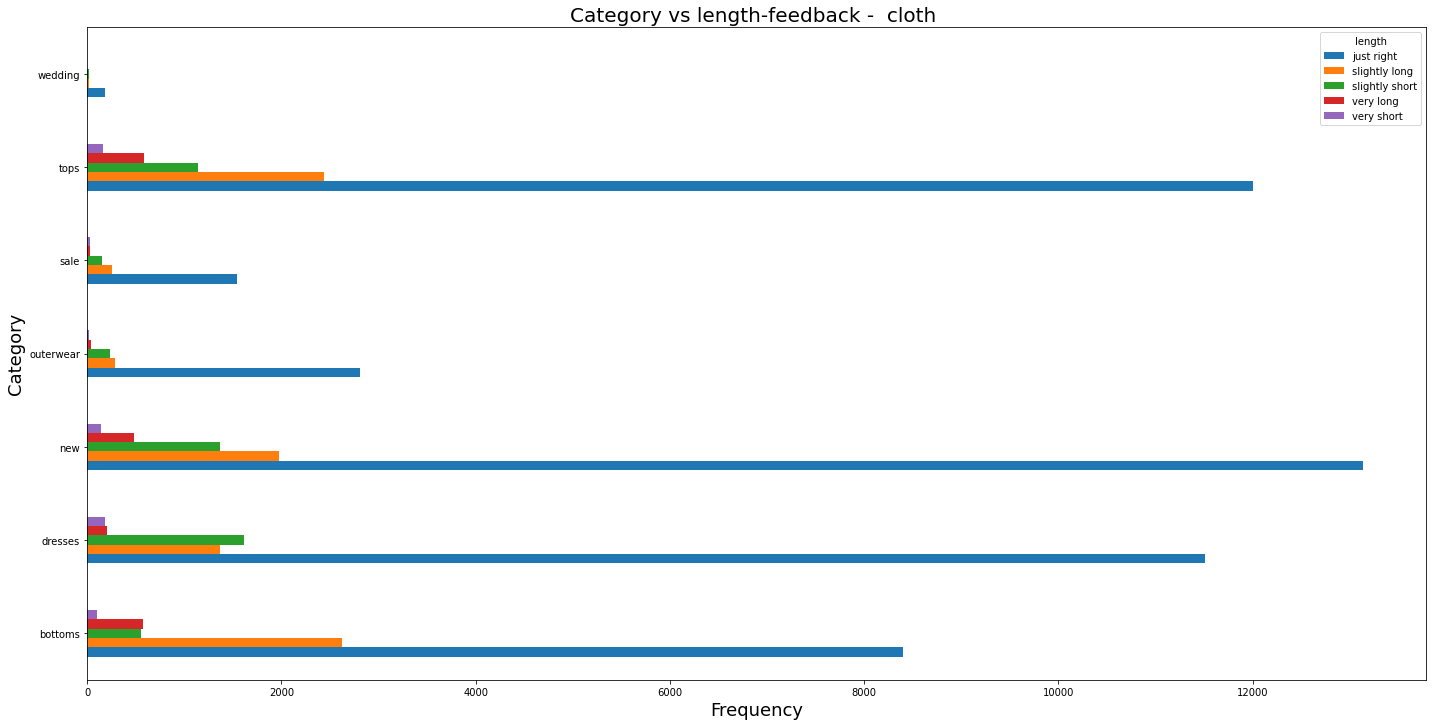

In [256]:
#Category vs Length

cat_len = g_by_category['length'].value_counts()
cat_len = cat_len.unstack()
plot_barh(cat_len, 'length')

#Most tops, dresses, new have just right length

In [257]:
# function to to convert feet to inches

def get_cms(x):
    if type(x) == type(1.0):
        return
    #print(x)
    try: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    except:
        return (int(x[0])*30.48)

# apply on train data    
df_train.height = df_train.height.apply(get_cms)

# apply on testing set
df_test.height = df_test.height.apply(get_cms)

In [258]:
#Missing values
print(df_train.isnull().sum())

item_id         0
size            0
quality        54
cup_size     4952
hips        21332
bra_size     4752
category        0
height        886
length         29
fit             0
user_id         0
dtype: int64


In [259]:
#Missing values imputation

# drop missing values
#df_train.dropna(subset=['height','length','quality'],inplace=True)
#df_test.dropna(subset=['height','length','quality'],inplace=True)

#Imputing missing values with median
df_train['height'].fillna((df_train['height'].median()), inplace=True)
df_test['height'].fillna((df_test['height'].median()), inplace=True)



df_train['quality'].fillna((df_train['quality'].median()), inplace=True)
df_test['quality'].fillna((df_test['quality'].median()), inplace=True)

# fill missing values with mean
df_train['bra_size'].fillna((df_train['bra_size'].mean()), inplace=True)
df_test['bra_size'].fillna((df_test['bra_size'].mean()), inplace=True)

df_train['hips'].fillna((df_train['hips'].mean()), inplace=True)
df_test['hips'].fillna((df_test['hips'].mean()), inplace=True)

# fill missing value with mode
mode_1 = df_train['cup_size'].mode()[0]
mode_2 = df_test['cup_size'].mode()[0]
df_train['cup_size']=df_train['cup_size'].replace(np.nan,mode_1)
df_test['cup_size']=df_test['cup_size'].replace(np.nan,mode_2)

mode_l1 = df_train['length'].mode()[0]
mode_l2 = df_test['length'].mode()[0]
df_train['length']=df_train['length'].replace(np.nan,mode_l1)
df_test['length']=df_test['length'].replace(np.nan,mode_l2)

print(df_train.isnull().sum())

item_id     0
size        0
quality     0
cup_size    0
hips        0
bra_size    0
category    0
height      0
length      0
fit         0
user_id     0
dtype: int64


In [260]:
# one hot encoding
df_train=pd.get_dummies(data=df_train,columns=["category", "cup_size","length"],prefix=["category", "cup_size","length"])
df_test=pd.get_dummies(data=df_test,columns=["category", "cup_size","length"],prefix=["category", "cup_size","length"])

### Model building


In [261]:
#Splitting training set

y=df_train['fit']
X=df_train.drop(['fit'],axis=1)

print(X.head())
print(y.head())


#we split 75% of the data to training set while 25% of the data to validation 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)

#X_train, X_valid shape
print(X_train.shape)
print(X_valid.shape)

   item_id  size  quality  hips  bra_size  height  user_id  category_bottoms  \
0   136482    15      3.0  36.0      36.0  162.56   357490                 0   
1   723977    15      5.0  42.0      36.0  172.72   897280                 1   
2   647551     8      4.0  36.0      34.0  162.56   279853                 0   
3   404557    12      3.0  44.0      32.0  165.10   912482                 0   
4   414857    15      3.0  38.0      38.0  175.26   978354                 0   

   category_dresses  category_new  category_outerwear  category_sale  \
0                 0             1                   0              0   
1                 0             0                   0              0   
2                 0             0                   0              0   
3                 0             1                   0              0   
4                 0             1                   0              0   

   category_tops  category_wedding  cup_size_a  cup_size_aa  cup_size_b  \
0          

In [262]:
# Defining the decision tree algorithm

dtree=DecisionTreeClassifier(criterion='gini', max_depth = 5, min_samples_leaf=100 , random_state=42 )
dtree.fit(X_train,y_train)

# Predicting the values of validation data
y_dtree_pred = dtree.predict(X_valid)
print("Classification report - \n", classification_report(y_valid,y_dtree_pred))

#accuracy_score
accuracy_score(y_valid,y_dtree_pred)

Classification report - 
               precision    recall  f1-score   support

         fit       0.71      0.97      0.82     11480
       large       0.56      0.09      0.15      2486
       small       0.50      0.10      0.17      2592

    accuracy                           0.70     16558
   macro avg       0.59      0.39      0.38     16558
weighted avg       0.66      0.70      0.62     16558



0.701111245319483

In [264]:
# parameters for grid search (using best_param)
parameters = {'max_depth':[5, 7, 9, 15, 20],'criterion':['gini','entropy'],'min_samples_leaf':[200, 210, 250, 300]}

# Decision tree classifier model
model=DecisionTreeClassifier(random_state=6)

# grid search on decision tree classifier
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)
grid.fit(X_train, y_train)

# Predicting the values of validation data
y_grid_pred = grid.predict(X_valid)
print("Classification report - \n", classification_report(y_valid,y_grid_pred))

#accuracy_score
accuracy_score(y_valid,y_grid_pred)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   23.0s finished


Classification report - 
               precision    recall  f1-score   support

         fit       0.72      0.96      0.82     11480
       large       0.54      0.19      0.28      2486
       small       0.54      0.09      0.16      2592

    accuracy                           0.71     16558
   macro avg       0.60      0.41      0.42     16558
weighted avg       0.66      0.71      0.64     16558



0.7060635342432661

In [265]:
#Best parameters dtree
grid.best_params_

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 250}

### Prediction on the test data and creating the submission file.


In [266]:
#the id column in a separate variable : test_id

test_id = df_test['id']
df_test.drop(['id'], axis=1, inplace=True) 


#Test data shape and columns names
print(df_test.shape)
print(df_test.columns)

(16558, 31)
Index(['item_id', 'size', 'quality', 'hips', 'bra_size', 'height', 'user_id',
       'category_bottoms', 'category_dresses', 'category_new',
       'category_outerwear', 'category_sale', 'category_tops',
       'category_wedding', 'cup_size_a', 'cup_size_aa', 'cup_size_b',
       'cup_size_c', 'cup_size_d', 'cup_size_dd/e', 'cup_size_ddd/f',
       'cup_size_dddd/g', 'cup_size_h', 'cup_size_i', 'cup_size_j',
       'cup_size_k', 'length_just right', 'length_slightly long',
       'length_slightly short', 'length_very long', 'length_very short'],
      dtype='object')


In [267]:
#make prediction : fit
y_test_pred = grid.predict(df_test)

#Making df for submission
subm=pd.DataFrame({"Id": test_id,"fit": y_test_pred})
print(subm.head())

      Id  fit
0  36962  fit
1  24517  fit
2  46688  fit
3  14851  fit
4   8526  fit


In [269]:
# To CSV for submission
subm.to_csv('fit.csv',index=False)

#from google.colab import files
#files.download('fit.csv') 